In [1]:
# authorize google account to use bigquery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

# authorize drive to pull model
from google.colab import drive
drive.mount('/content/drive')

# pull data for repo from bigquery
project_id = 'uic-capstone-int'
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

Authenticated
Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/Cloudbakers/Assets/')

In [3]:
import warnings
import pandas as pd

# !pip install --upgrade google-cloud-bigquery

warnings.filterwarnings("ignore")

In [41]:
#Reading most famous Repositories for training model

id = pd.read_csv('Most_number_of_pushes_repoID.csv')

In [42]:
id = id.iloc[5400:5600,:]

In [43]:
id=id['repoID'].tolist()

In [44]:
len(id)

200

# Data Extraction

In [46]:
import json
import requests
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
import config
from termcolor import colored
import threading
import time
import seaborn as sns

In [47]:
github_api = "https://api.github.com"
gh_session = requests.Session()
gh_session.auth = (config.GITHUB_USERNAME, config.GITHUB_TOKEN)

In [48]:
# def thread_function(name):
#     time.sleep(60)
    
    



In [49]:
def commits_of_repo_github(repo, owner, api):
    commits = []
    next = True
    i = 1
    while next == True:
        url = api + '/repos/{}/{}/commits?page={}&per_page=100'.format(owner, repo, i)
        commit_pg = gh_session.get(url = url)
        commit_pg_list = [dict(item, **{'repo_name':'{}'.format(repo)}) for item in commit_pg.json()]    
        commit_pg_list = [dict(item, **{'owner':'{}'.format(owner)}) for item in commit_pg_list]
        commits = commits + commit_pg_list
        if 'Link' in commit_pg.headers:
            if 'rel="next"' not in commit_pg.headers['Link']:
                next = False
        i = i + 1
    return commits

In [50]:
def create_commits_df(repo, owner, api):
    commits_list = commits_of_repo_github(repo, owner, api)
    return json_normalize(commits_list)

In [51]:
def RESTdb(repo_name_list):

      repo_name_df = pd.DataFrame(repo_name_list,columns=['owner_repo'])
      repo_name_df[['owner','repo']] = repo_name_df.owner_repo.str.split("/",n=1,expand=True)
      get_commit = pd.DataFrame()
      for k in range(0,len(repo_name_df)):
        
        
        try:
            
            REST_df = create_commits_df(repo_name_df.iloc[k].repo, repo_name_df.iloc[k].owner, github_api)
            REST_df = REST_df[['sha','commit.committer.date','commit.committer.email']]
            REST_df['commit.committer.date'] = pd.to_datetime(REST_df['commit.committer.date'])
            REST_df['commit.committer.date'] = REST_df['commit.committer.date'].dt.date
            REST_df.rename({'commit.committer.date':'committed_date','commit.committer.email':'email', 'sha':'commit'}, axis=1, inplace=True)
            get_commit = get_commit.append(REST_df, ignore_index=True)
            
        except:
            continue
      return get_commit

  

In [52]:
df = pd.DataFrame()

sql='''

SELECT FORMAT_DATETIME("%Y-%m-%d", DATETIME(date)) AS year_month, repoID, repo_name, type, count (*) ct
FROM
(

SELECT type,created_at as date, repo.id as repoID, repo.name as repo_name
FROM githubarchive.year.2015
WHERE type IN ('PushEvent','IssuesEvent','ForkEvent','PullRequestEvent','WatchEvent','IssueCommentEvent','CommitComentEvent') AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT type,created_at as date, repo.id as repoID, repo.name as repo_name
FROM githubarchive.year.2016
WHERE type IN ('PushEvent','IssuesEvent','ForkEvent','PullRequestEvent','WatchEvent','IssueCommentEvent','CommitComentEvent') AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT type,created_at as date, repo.id as repoID, repo.name as repo_name
FROM githubarchive.year.2017
WHERE type IN ('PushEvent','IssuesEvent','ForkEvent','PullRequestEvent','WatchEvent','IssueCommentEvent','CommitComentEvent') AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT type,created_at as date, repo.id as repoID, repo.name as repo_name
FROM githubarchive.year.2018
WHERE type IN ('PushEvent','IssuesEvent','ForkEvent','PullRequestEvent','WatchEvent','IssueCommentEvent','CommitComentEvent') AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT type,created_at as date, repo.id as repoID, repo.name as repo_name
FROM githubarchive.year.2019
WHERE type IN ('PushEvent','IssuesEvent','ForkEvent','PullRequestEvent','WatchEvent','IssueCommentEvent','CommitComentEvent') AND repo.id IN UNNEST(@ids)
)
GROUP BY 1,2,3,4
ORDER BY 1;'''


job_configuration = bigquery.QueryJobConfig(
    query_parameters=[bigquery.ArrayQueryParameter("ids", "INT64", id),]
)


dfx = client.query(
    sql,
    job_config=job_configuration
    ).to_dataframe()


#-------------------------Commit_author_count event creation-------------------

job_configuration = bigquery.QueryJobConfig(
    query_parameters=[bigquery.ArrayQueryParameter("ids", "INT64", id),]
)

sql = '''
SELECT FORMAT_DATETIME("%Y-%m-%d", DATETIME(date)) AS year_month, repoID, repo_name, COUNT( DISTINCT a_id) AS ct
FROM (
    
SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2015
WHERE type = 'CommitCommentEvent' AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2016
WHERE type = 'CommitCommentEvent' AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2017
WHERE type = 'CommitCommentEvent' AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2018
WHERE type = 'CommitCommentEvent' AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2019
WHERE type = 'CommitCommentEvent' AND repo.id IN UNNEST(@ids)

)
GROUP BY 1,2,3
ORDER BY 1;'''

Cac = client.query(
    sql,
    job_config=job_configuration
    ).to_dataframe()
Cac['type'] = 'Commit_author_count'


#Union
dfx = pd.concat([dfx, Cac])


#-------------------------Issue_author_count event creation-------------------

job_configuration = bigquery.QueryJobConfig(
    query_parameters=[bigquery.ArrayQueryParameter("ids", "INT64", id),]
)

sql = '''
SELECT FORMAT_DATETIME("%Y-%m-%d", DATETIME(date)) AS year_month, repoID, repo_name, COUNT( DISTINCT a_id) AS ct
FROM (
    
SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2015
WHERE type = 'IssueCommentEvent' AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2016
WHERE type = 'IssueCommentEvent' AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2017
WHERE type = 'IssueCommentEvent' AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2018
WHERE type = 'IssueCommentEvent' AND repo.id IN UNNEST(@ids)

UNION ALL

SELECT created_at as date, repo.id as repoID, repo.name as repo_name, actor.id AS a_id
FROM githubarchive.year.2019
WHERE type = 'IssueCommentEvent' AND repo.id IN UNNEST(@ids)

)
GROUP BY 1,2,3
ORDER BY 1;'''

Iac = client.query(
    sql,
    job_config=job_configuration
    ).to_dataframe()
Iac['type'] = 'Issue_author_count'


#Union
dfx = pd.concat([dfx, Iac])

counter =1

for i in range(0,len(id)):
  print(colored(counter,color='white'))
  counter+=1

  dfPushes = dfx.loc[(dfx['type'] == 'PushEvent') & (dfx['repoID']==id[i])]
  dfPushes.rename(columns={'ct':'number_of_pushes'}, inplace=True)
  repo_name_list = dfPushes['repo_name'].unique().tolist()

  dfForks = dfx.loc[(dfx['type'] == 'ForkEvent') & (dfx['repoID']==id[i])]
  dfForks.rename(columns={'ct':'number_of_forks'}, inplace=True)
  
  dfPulls = dfx.loc[(dfx['type'] == 'PullRequestEvent') & (dfx['repoID']==id[i])]
  dfPulls.rename(columns={'ct':'number_of_pulls'}, inplace=True)
  
  dfBookmarks = dfx.loc[(dfx['type'] == 'WatchEvent') & (dfx['repoID']==id[i])]
  dfBookmarks.rename(columns={'ct':'number_of_bookmarks'}, inplace=True)


  dfIssues = dfx.loc[(dfx['type'] == 'IssuesEvent') & (dfx['repoID']==id[i])]
  dfIssues.rename(columns={'ct':'number_of_issues'}, inplace=True)


  dfIssuecomment = dfx.loc[(dfx['type'] == 'IssueCommentEvent') & (dfx['repoID']==id[i])]
  dfIssuecomment.rename(columns={'ct':'issue_comment_count'}, inplace=True)


  dfIssue_author_count = dfx.loc[(dfx['type'] == 'Issue_author_count') & (dfx['repoID']==id[i])]
  dfIssue_author_count.rename(columns={'ct':'issue_author_count'}, inplace=True)


  dfCommitcomment = dfx.loc[(dfx['type'] == 'CommitComentEvent') & (dfx['repoID']==id[i])]
  dfCommitcomment.rename(columns={'ct':'commit_comment_count'}, inplace=True)

  dfCommit_author_count = dfx.loc[(dfx['type'] == 'Commit_author_count') & (dfx['repoID']==id[i])]
  dfCommit_author_count.rename(columns={'ct':'commit_author_count'}, inplace=True)
  
  
  merge1 = pd.merge(dfPushes,dfForks,how='outer', on='year_month')
  merge2 = pd.merge(merge1, dfPulls, how='outer', on='year_month')
  merge3 = pd.merge(merge2, dfBookmarks, how='outer', on='year_month')
  merge4 = pd.merge(merge3, dfIssuecomment, how='outer', on='year_month')
  merge5 = pd.merge(merge4,dfCommitcomment,how='outer',on='year_month')
  merge6 = pd.merge(merge5, dfIssues, how='outer',on='year_month')
  merge7 = pd.merge(merge6, dfIssue_author_count, how='outer',on='year_month')
  merge8 = pd.merge(merge7, dfCommit_author_count, how='outer',on='year_month')
  merge8.drop(['repoID_x','repoID_y','type_x','type_y','type', 'repo_name_x','repo_name_y', 'repo_name'], axis=1, inplace=True)
  merge8['repoID']=id[i]
  merge8.sort_values(by='year_month',ascending=True,inplace=True)
  
  merge8['year_month']=pd.to_datetime(merge6['year_month'])
  merge8.rename({'year_month': 'datetime'}, axis=1, inplace=True)
  merge8.index=merge8['datetime']
  merge8.drop('datetime',axis=1,inplace=True)

  WeeklyTS = pd.DataFrame()
  WeeklyTS = merge8.resample('W').sum()
  WeeklyTS.reset_index(level=0, inplace=True)

  # repo_name_tuple = tuple(repo_name_list)


  dfCommits = RESTdb(repo_name_list)
  
  if dfCommits.empty:
    print(colored('No commits data for repoID: %d'%id[i], color='red'))
    continue

    # try:
    #   print('Failed Commits data Extraction from REST API for repoID: %d' %id[i] + '...gathering data from BigQuery')
    #   sql = '''

    #   SELECT   commit, committer.email, DATE(TIMESTAMP_SECONDS(committer.date.seconds)) AS committed_date
    #   FROM `bigquery-public-data.github_repos.commits`
    #   WHERE EXISTS (
    #     SELECT 1 FROM UNNEST(repo_name) name 
    #     WHERE name IN {} AND EXTRACT(YEAR FROM DATE(TIMESTAMP_SECONDS(committer.date.seconds))) >2015
    #     )
    #   ORDER BY 3

    #   '''.format(repo_name_tuple)

    #   dfCommits = client.query(sql).to_dataframe() 

    # except:
    #   print('No data obtained from REST or Bigquery') 
    #   continue
  else:
    print(colored('Successful Commits data Extraction from REST API for repoID: %d' %id[i], color='green'))


  dfCommits['committed_date']=pd.to_datetime(dfCommits['committed_date'])
  dfCommits.index=dfCommits['committed_date']
  dfCommits.drop('committed_date',axis=1,inplace=True)
  Weekly_commit_TS = pd.DataFrame()
  Weekly_commit_TS = dfCommits.resample('W').agg({'commit': 'count', 'email': 'nunique'})
  Weekly_commit_TS.rename(columns={"commit":"commit_count","email":"unique_committer_count"}, inplace=True)
  Weekly_commit_TS.reset_index(level=0, inplace=True)
  Weekly_commit_TS.rename(columns={'committed_date':'datetime'}, inplace=True)
  WeeklyTS = pd.merge(WeeklyTS,Weekly_commit_TS,how='outer', on='datetime')
  WeeklyTS.drop('repoID', axis=1, inplace=True)
  WeeklyTS.fillna(0, inplace=True)
  WeeklyTS['Total_count'] = WeeklyTS.drop('datetime',axis=1).sum(axis=1)
  

  # Setting Threshold in terms of percentage of drop
  Threshold = 0.1
  for j in range(5,len(WeeklyTS)):
    Avg = WeeklyTS['Total_count'].iloc[j-5:j,].mean()
    diff = WeeklyTS['Total_count'].iloc[j] - WeeklyTS['Total_count'].iloc[j-1]
    if diff>=0:
      WeeklyTS.loc[j,'Status'] = 1
    else:
      if abs(diff)/Avg < Threshold:
        WeeklyTS.loc[j,'Status'] = 1
      else:
        WeeklyTS.loc[j,'Status'] = 0


  WeeklyTS.index = WeeklyTS['datetime']
  WeeklyTS.drop('datetime', axis=1, inplace=True)
  WeeklyTS.insert(0, 'year', WeeklyTS.index.year)
  WeeklyTS.insert(1, 'month', WeeklyTS.index.month)
  WeeklyTS.insert(2, 'day', WeeklyTS.index.day)
  WeeklyTS.reset_index(level=0, inplace=True)
  WeeklyTS['repoID']=id[i]


  df=df.append(WeeklyTS, ignore_index=True)



1
Successful Commits data Extraction from REST API for repoID: 16717528
2
Successful Commits data Extraction from REST API for repoID: 137518754
3
Successful Commits data Extraction from REST API for repoID: 170180009
4
Successful Commits data Extraction from REST API for repoID: 78689332
5
Successful Commits data Extraction from REST API for repoID: 48291588
6
No commits data for repoID: 26854649
7
Successful Commits data Extraction from REST API for repoID: 121929008
8
Successful Commits data Extraction from REST API for repoID: 19245921
9
Successful Commits data Extraction from REST API for repoID: 126496611
10
Successful Commits data Extraction from REST API for repoID: 114834469
11
Successful Commits data Extraction from REST API for repoID: 24410210
12
Successful Commits data Extraction from REST API for repoID: 31406230
13
Successful Commits data Extraction from REST API for repoID: 180464036
14
Successful Commits data Extraction from REST API for repoID: 14716368
15
Successful 

In [53]:
df.to_csv("Bigger_Training_dataset_5400_5600.csv")

# Concatenating datasets

In [ ]:
ds_1_500 = pd.read_csv('Bigger_Training_dataset_1_500.csv')
ds_1000_1500 = pd.read_csv('Bigger_Training_dataset_1000_1500.csv')
ds_1500_2000 = pd.read_csv('Bigger_Training_dataset_1500_2000.csv')
ds_2000_2500 = pd.read_csv('Bigger_Training_dataset_2000_2500.csv')
ds_3000_3100 = pd.read_csv('Bigger_Training_dataset_3000_3100.csv')
ds_3500_3600 = pd.read_csv('Bigger_Training_dataset_3500_3600.csv')
ds_3600_3700 = pd.read_csv('Bigger_Training_dataset_3600_3700.csv')
ds_3800_3900 = pd.read_csv('Bigger_Training_dataset_3800_3900.csv')
ds_3900_4000 = pd.read_csv('Bigger_Training_dataset_3900_4000.csv')
ds_4200_4500 = pd.read_csv('Bigger_Training_dataset_4200_4500.csv')
ds_4500_4800 = pd.read_csv('Bigger_Training_dataset_4500_4800.csv')
ds_4800_5000 = pd.read_csv('Bigger_Training_dataset_4800_5000.csv')
ds_5000_5200 = pd.read_csv('Bigger_Training_dataset_5000_5200.csv')
ds_5400_5600 = pd.read_csv('Bigger_Training_dataset_5400_5600.csv')

In [ ]:
ds = pd.concat([ds_1_500, ds_1000_1500, ds_1500_2000, ds_2000_2500, ds_3000_3100, ds_3500_3600, ds_3600_3700, ds_3800_3900, ds_3900_4000, ds_4200_4500, ds_4500_4800, ds_4800_5000, ds_5000_5200, ds_5400_5600 ])

In [ ]:
ds = ds[ds['Total_count'].notna()]

In [ ]:
ds.drop('Unnamed: 0', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


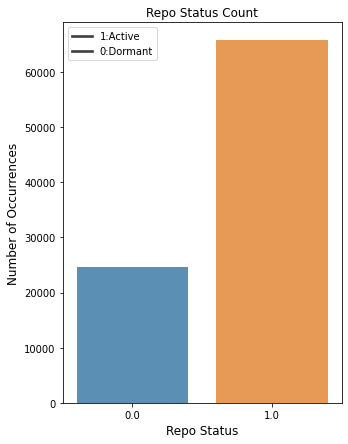

In [ ]:
status_count  = ds['Status'].value_counts()
fig = plt.figure(facecolor='white', figsize=(5,7) )
sns.barplot(status_count.index, status_count.values, alpha=0.8)
plt.title('Repo Status Count')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Repo Status', fontsize=12)
plt.legend(['1:Active','0:Dormant'])
plt.show()

In [ ]:
ds

,datetime,year,month,day,number_of_pushes,number_of_forks,number_of_pulls,number_of_bookmarks,issue_comment_count,commit_comment_count,number_of_issues,issue_author_count,commit_author_count,commit_count,unique_committer_count,repoID
0,2018-02-04,2018.0,2.0,4.0,97917.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118083636.0
1,2018-02-11,2018.0,2.0,11.0,228101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,118083636.0
2,2018-02-18,2018.0,2.0,18.0,192455.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118083636.0
3,2018-02-25,2018.0,2.0,25.0,176103.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118083636.0
4,2018-03-04,2018.0,3.0,4.0,134716.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118083636.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6291,2019-06-09,2019.0,6.0,9.0,333.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1392.0,3.0,144863968.0
6292,2019-06-16,2019.0,6.0,16.0,526.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,2148.0,4.0,144863968.0
6293,2019-06-23,2019.0,6.0,23.0,167.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,820.0,3.0,144863968.0
6294,2019-06-30,2019.0,6.0,30.0,160.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,652.0,3.0,144863968.0


In [ ]:
attributes = ['commit_count','number_of_bookmarks','number_of_pushes','number_of_forks','number_of_pulls','unique_committer_count','issue_comment_count','issue_author_count','number_of_issues','commit_comment_count','commit_author_count']
weights = [0.265982,0.151779,0.111914,0.098709,0.094123,0.090812,0.071414,0.059612,0.040631,0.007819,0.007206]

In [ ]:
ds.drop(['Total_count', 'Status'], axis=1, inplace=True)

In [ ]:
ds['Risk_Score'] = ds[attributes].mul(weights).sum(1)
ds

,datetime,year,month,day,number_of_pushes,number_of_forks,number_of_pulls,number_of_bookmarks,issue_comment_count,commit_comment_count,number_of_issues,issue_author_count,commit_author_count,commit_count,unique_committer_count,repoID,Risk_Score
0,2018-02-04,2018.0,2.0,4.0,97917.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118083636.0,10958.283138
1,2018-02-11,2018.0,2.0,11.0,228101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,118083636.0,25528.318090
2,2018-02-18,2018.0,2.0,18.0,192455.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118083636.0,21538.408870
3,2018-02-25,2018.0,2.0,25.0,176103.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118083636.0,19708.391142
4,2018-03-04,2018.0,3.0,4.0,134716.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118083636.0,15076.606424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6291,2019-06-09,2019.0,6.0,9.0,333.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1392.0,3.0,144863968.0,408.727972
6292,2019-06-16,2019.0,6.0,16.0,526.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,2148.0,4.0,144863968.0,631.594701
6293,2019-06-23,2019.0,6.0,23.0,167.0,0.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,820.0,3.0,144863968.0,238.855651
6294,2019-06-30,2019.0,6.0,30.0,160.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,652.0,3.0,144863968.0,192.163678


In [ ]:
WeeklyTS = ds[['year','month','day','repoID','Risk_Score']]

In [ ]:
WeeklyTS = WeeklyTS[WeeklyTS.year>2014]

In [ ]:
WeeklyTS.to_csv('BiggerDS-Part_')